<a href="https://colab.research.google.com/github/AlirezaPNouri/Papers/blob/main/ComprehensiveCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this comprehensive code, all the steps of CoRBS are included. 11/12/2022 

In [1]:
#install needed packages
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 34.6 MB/s 
     |████████████████████████████████| 163 kB 60.7 MB/s 
     |████████████████████████████████| 7.6 MB 51.2 MB/s 


In [2]:
#Import needed packages
from gensim.models.doc2vec import Doc2Vec, TaggedDocument 
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from numpy import median, array, exp
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from transformers import BertTokenizer, TFBertModel
import copy
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pickle
import re
import requests
import string
import tensorflow as tf


In [135]:
#Download needed packages
nltk.download('punkt')

#### Load the pre-traiend BERT model #####################
##########################################################
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [4]:
#load needed objects

In [5]:
#constant variables
dataset_covid_link = 'https://raw.githubusercontent.com/AlirezaPNouri/Storytelling/main/datasets/short_parsed_covid_data.csv'
dataset_NYT_link = 'https://raw.githubusercontent.com/AlirezaPNouri/Storytelling/main/datasets/short_parsed_NYT_data.csv'
dataset_percentage = .6
# MAX_DATA = 100
# doc_list =[item for item in range(MAX_DATA)]
MAX_SENTENCE_LENGTH = 350
MIN_SENTENCE_LENGTH = 200
jump = 3 # jump size for gradient decent
MAX_FEATURE_SIZE = 20 # max size of the gradient descent vector
range_n_clusters = [2, 3, 4, 5, 6] #number of different clustering to compare the performance of the model over different clustering
threshold_cluster_overlapping = 0.7 # to consider two clsuters are similar
stopwords = ['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that','these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','don','should','now', 'of', 'within']
story_picked = 92



In [6]:
# download the dataset as a zip file from the git repo
def dataset_downloader(str_):
  """
  This function download a dataset
  Arguments:
    str_: the name of the dataset. It can be covid or NYT
  Returns:
    df: a pandas dataframe
  """
  if str_ == 'NYT':
    url = dataset_NYT_link
  elif str_ == 'covid':
    url = dataset_covid_link
  else:
    print('dataset is not choose correctly!')

  print('Downloading dataset...')
  res = requests.get(url, allow_redirects=True)
  with open('small_dataset.csv','wb') as file:
      file.write(res.content)
  print('Download is done!')
  df = pd.read_csv("/content/small_dataset.csv", header= None, skiprows=1)
  if str_ == 'covid':
    df.columns = ['id', 'title', 'content', 'publish_time', 'author']
  elif str_ == 'NYT':
    df.columns = ['id', 'title', 'content', 'author', 'publish_time']
  
  df = df.dropna(how='any', axis=0)
  print('dataset size after removing non-value cells is {}'.format(df.shape))
  # reduce the size of dataset to dataset_percentage*dataset.shape
  df = df.sample(frac=dataset_percentage)
  print('The new size of dataset is {} and the columns are {}'.format(df.shape, df.columns.values ))
  # remove the content that has less than MIN_SENTENCE_LENGTH words 
  df = df[df['content'].apply(lambda x : len(x.split(' ')))>=MIN_SENTENCE_LENGTH]

  # keep the first 500 words in content
  df['content'] = df['content'].apply(lambda x : ' '.join(x.split(' ')[:MAX_SENTENCE_LENGTH]))
  return df


In [7]:
# today_covid_df = dataset_downloader('covid')
# today_nyt_df = dataset_downloader('NYT')

In [8]:
def special_char_remover(str_):
  """
  This function removes any special characters from a text
  Arguments:
    str_: a string
  Returns:
    A string
  """
  return ' '.join(''.join(w for w in m if w.isalnum()) for m in str_.split(' '))

In [9]:
### create embedding vector for each token in each document
def bert_embedding_generator(df_):
  """
  Generate the embedding for a document
  Arguments:
    df_: a pandas dataframe 
  Returns:
    Embedding_dict: a dictionary of document indices and [embedding vectors, content]
  """
  Embedding_dict = dict()
  print('Start to generate the embedding vector for documents')
  c = 0
  for index, row in df_.iterrows():
    content_ = row['content']
    tmp_e = model(tf.constant(tokenizer.encode(content_))[None, :])[0][0]
    tmp_d = tokenizer.tokenize(content_)
    temp_dict = dict()
    temp_dict['cls'] = tmp_e[0]
    for emb, tok in zip(tmp_e[1:-1], tmp_d):
      temp_dict[tok] = emb
    temp_dict['sep'] = tmp_e[-1]
    Embedding_dict[row['id']] = temp_dict
    c +=1
  print('Embedding is done for {} documents.'.format(c))
  return Embedding_dict

In [10]:
#### Create a list of dataframe out of the dataset. Each dataframe belongs to a timestamp #############
#######################################################################################################
# use 10 days as time interval
def timestamps_generator(df_):
  """
  This function collect data related to each timestamp separately in a dataframe
  Arguments:
    df_: a pandas dataframe
  Returns:
    df_list: a list of all timestamps data [df_1, df_2, ...]
  """
  time_stamp = set()
  df_list= list()
  for index, row in df_.iterrows():
    time_stamp.add(row['publish_time'][0:4])
  # this is the new line added by ali at 11/08/2022
  time_stamp = sorted(time_stamp)
  # this is the new line added by ali at 11/08/2022
  for time_interval in time_stamp:
    new_df = df_[df_['publish_time'].str.slice(0, 4)== time_interval]
    if new_df.shape[0]>5: #minimum number of doc in a timestamp
      df_list.append(new_df)
  return df_list

In [11]:
def time_fixer(str_):
  """
  This function convert a date from x/x/xxxx to 0x0xxxxx
  Arguments:
    str_: a date in a string format
  Returns:
    a string without any / and all months and days are in two digit
  """
  t_slot = str_.split('/')
  t_slot[0] = t_slot[0] if len(t_slot[0]) == 2 else '0'+t_slot[0]
  t_slot[1] = t_slot[1] if len(t_slot[1]) == 2 else '0'+t_slot[1]
  return ''+t_slot[0]+t_slot[1]+t_slot[2]

In [12]:
# print(time_fixer(today_nyt_df['publish_time'].iloc[10]))
# print(time_fixer(today_covid_df['publish_time'].iloc[10]))

In [13]:
def find_similarity(Embed_):
  """
  This function calculate the cosine similarity between each pair of words in a document and sort them as a new vector
  Arguments:
    Embed_: a dictionary of all doc and embedding seperated into their timestamps {timestamp1 {doc1{token1: embedding, token2: embedding}}}
  Returns:
    neighbor_ts_doc: a dictionary of all timestamps, docs and the neighbor similarity for each word
  """
  tmp_collector = dict()
  neighbor_ts_doc = dict()
  for ts_ in tqdm(Embed_.keys()):
    temp = Embed_[ts_]
    final_list = dict()
    for doc in temp.keys():
      if doc in tmp_collector.keys():
        final_list[doc] = tmp_collector[doc]
      else:
        neighbor_dict = dict()
        track_dict = dict()
        
        for f_word, f_emb in temp[doc].items():
          temp_list = list()
          
          for s_word, s_emb in temp[doc].items():
            if (s_word, f_word) in track_dict.keys():
              temp_list.append(track_dict[(s_word, f_word)])
            else:
              track_dict[(f_word, s_word)] = cosine_similarity([f_emb],[s_emb])[0][0]
              temp_list.append(track_dict[(f_word, s_word)])
          
          neighbor_dict[f_word] =sorted(temp_list, reverse=True)[1:] # ignore the cosine similarity between a word and itself

        final_list[doc] = neighbor_dict
        tmp_collector[doc] = neighbor_dict

      # print('Document {} is done!'.format(doc))
    neighbor_ts_doc[ts_] = final_list
  return neighbor_ts_doc

In [14]:

#sigmoid function
def amplifier_function(vec_):
  """
  This function receives a vector and applies the curve below to reward the first part of the vector and to penalize the last part of the vector
  Arguments:
    vec_: a vector
  Results:
    g: a vector
  """
  z = array(vec_)
  z = z/np.linalg.norm(z)
  g = 1 / (1 + exp(-z))
  return g

In [15]:
def gradient_calculator(ns_dict, n_step, MAX_FEATURE_SIZE):
  """
  This function receives all the similarity neighbor for each word in all documents and apply gradient descent over them by the step
  Arguments:
    ns_dict: a dictinary of all neighbor similarity for all tokens
    n_step: the jump value for gradient discent
    MAX_FEATURE_SIZE: the maximum size for each feature victor
  Returns:
    final_dict: a dictionary of all gradient discent of tokens neighbor similarity
  """
  final_dict = dict()
  for ts_ in tqdm(ns_dict.keys()):
    gradient_descent_neighbors = dict()
    word_neighbor_similarity = ns_dict[ts_]
    for doc in word_neighbor_similarity.keys():
      temp_dict = dict()
      for word, embedding in word_neighbor_similarity[doc].items():
        vec_size = len(embedding)
        vec_size -= vec_size%n_step
        embedding = embedding[0:vec_size]
        new_list = [embedding[x:x+n_step] for x in range(0, vec_size, n_step)]
        tmp_list = list()
        for ele in new_list:
          m1,b1 = np.polyfit(np.arange(0, n_step), ele, 1)
          tmp_list.append(m1)
        temp_dict[word] = amplifier_function(tmp_list[0:MAX_FEATURE_SIZE])
      gradient_descent_neighbors[doc] = temp_dict
      # print('Document {} is done!'.format(doc))
    final_dict[ts_] = gradient_descent_neighbors
  return final_dict

In [16]:

# clustering the tokens in each document. It creates differnt number of clustering

def cluster_maker(final_vec_):
  """
  This function generates clusters based on featur vectors
  Arguments:
    final_vec_: a dictionary of all gradient discent of tokens neighbor similarity
  Returns:
    total_clustering: a dictionary contains timestamps and clusters in each timestamp 
    total_centroid: a dictionart contains timestamps and centroids for each clusters
  """
  total_clustering = dict()
  total_centroid = dict()
  for ts_ in tqdm(final_vec_.keys()):
    gradient_descent_neighbors = final_vec_[ts_]
    all_clusters = dict()
    all_centroid = dict()
    for doc, featurs in gradient_descent_neighbors.items():
      clusters_per_doc = dict()
      centroids_per_doc = dict()
      for n_clusters in range_n_clusters:
        clusterer = KMeans(n_clusters=n_clusters, random_state=10, max_iter=100,)
        clusters_per_doc[n_clusters] = clusterer.fit_predict(list(featurs.values()))
        centroids_per_doc[n_clusters] = clusterer.cluster_centers_
      all_clusters[doc] = clusters_per_doc
      all_centroid[doc] = centroids_per_doc
      # print('Document {} is done!'.format(doc))
    total_clustering[ts_] = all_clusters
    total_centroid[ts_] = all_centroid
  return total_clustering, total_centroid
    

In [17]:
def sorted_clustering(all_gradient_descent_neighbors,all_clusters_dict, all_centroids_dict):
  final_clustering_dict = dict()
  for ts_ in tqdm(all_clusters_dict.keys()):
    gradient_descent_neighbors = all_gradient_descent_neighbors[ts_]
    all_centroid = all_centroids_dict[ts_]
    all_clusters = all_clusters_dict[ts_]
    #create a total clusters sorted dictionary
    ## the structure of total_docs_clusters  is {doc0: {number_of_clusters { cluster_number: {token0: closeness_to_centroid, token1: closeness_to_centroid ...} }}}
    total_docs_clusters = dict()
    for doc in all_clusters.keys():
      temp_cluster = all_clusters[doc]
      dic_for_clustering = dict()
      for n_cluster in range_n_clusters:
        temp_dict = dict()
        for la in range(n_cluster):
          temp_list = dict()
          for label_, value_ in zip(temp_cluster[n_cluster],gradient_descent_neighbors[doc].items()):
            if label_ == la:
              temp_list[value_[0]] = np.sum(np.square(value_[1] - all_centroid[doc][n_cluster][la]))
          temp_dict[la]=temp_list
        dic_for_clustering[n_cluster] = temp_dict
      total_docs_clusters[doc] = dic_for_clustering
      # print('Document {} is done!'.format(doc))
    final_clustering_dict[ts_] = total_docs_clusters
  return final_clustering_dict

In [18]:
def similar_doc(doc_one, doc_two):
  """
  #find similar documents
  """
  list_sim = list()
  for clu_1 in doc_one:
    total_jac = 0
    for clu_2 in doc_two:
      jac_val = jaccard_similarity(clu_1, clu_2)
      total_jac += jac_val
    # total_jac /= len(doc_two)
    list_sim.append(total_jac)
  return sum(list_sim)
  # return sum(list_sim)/(len(doc_one)*len(doc_two))   #with normalizing based on the number of word groups

In [49]:
def normalize_vec(vec, min_, max_):
  """
  # this function will receive a vector and the min and max of that vector and will return the normalized vec 
  """
  range_val = (max_ - min_)+0.0000001
  vec = [item/range_val for item in vec]
  min_vec = min(vec)
  vec = [item - min_vec for item in vec]
  return vec



def normalize_value(item, min_, max_):
  """
  # this function will receive a value of a vector, the min and the max of the vector and returns the normalized value
  """
  range_val = (max_ - min_)+0.0000001
  vec = (item-min_)/range_val
  return vec
def normalize_value_(vec):
  """
  # this function will receive a value of a vector, the min and the max of the vector and returns the normalized value
  """
  min_ = min(vec.values())
  max_ = max(vec.values())
  range_val = (max_ - min_)+0.0000001
  for doc in vec.keys():
    vec[doc] = (vec[doc] - min_) /range_val

  return vec

In [20]:
def normalizer(total_docs_clustering_):
  """
    normalize the similarity in each cluster. It goes and find the min and max values in each clustering and make those similarity between [0,1] (the similarity here is euclidean distance between each token and the centroid)

  """
  all_total_docs_clusters = dict()
  for ts_ in tqdm(total_docs_clustering_.keys()):
    total_docs_clusters = total_docs_clustering_[ts_]
    for doc in total_docs_clusters.keys():
      temp_doc = total_docs_clusters[doc]
      for cluster_rank in temp_doc.keys():
        temp_clustering = temp_doc[cluster_rank]
        min_sim = 1
        max_sim = 0
        for ind in temp_clustering.keys():
          for ele, val_ in temp_clustering[ind].items():
            min_sim = min_sim if min_sim<val_ else val_
            max_sim = max_sim if val_<max_sim else val_ 

        for ins in temp_clustering.keys():
          for el in total_docs_clusters[doc][cluster_rank][ins].keys():
            total_docs_clusters[doc][cluster_rank][ins][el] = normalize_value(total_docs_clusters[doc][cluster_rank][ins][el], min_sim, max_sim)
      # print('Document {} is done!'.format(doc))
    all_total_docs_clusters[ts_] = total_docs_clusters
  return all_total_docs_clusters

In [21]:
def stopword_remover(all_dict_):
  final_dict_w_stopword = dict()
  for ts_ in all_dict_.keys():
    total_docs_clusters = all_dict_[ts_]
    #remove stopwords
    total_docs_clusters_wo_stopwords = dict()
    for doc in total_docs_clusters.keys():
      temp_doc = {}
      for cluster_rank in total_docs_clusters[doc].keys():
        temp_clustering = {}
        for ins in total_docs_clusters[doc][cluster_rank].keys():
          temp_cluster = {}
          for items in total_docs_clusters[doc][cluster_rank][ins].items():
            if items[0] not in stopwords:
              temp_cluster[items[0]] = items[1]
          temp_clustering[ins] = temp_cluster
        temp_doc[cluster_rank] = temp_clustering
      total_docs_clusters_wo_stopwords[doc] = temp_doc
    final_dict_w_stopword[ts_] = total_docs_clusters_wo_stopwords
  return final_dict_w_stopword

In [22]:
# Jaccard index function
def jaccard_similarity(text1_list, text2_list):
  a = set(text1_list)
  b = set(text2_list)
  return len(a.intersection(b))/len(a.union(b))

In [23]:
# def word_group_generator(all_clusters_):
#   final_total_doc_word_group = dict()
#   for ts_ in tqdm(all_clusters_.keys()):
#     total_docs_clusters_wo_stopwords = all_clusters_[ts_]
#     total_doc_word_groups = dict()
#     for doc in total_docs_clusters_wo_stopwords.keys():
#       docs_clusters = total_docs_clusters_wo_stopwords[doc]
#       # print(docs_clusters)
#       temp_list_word_groups = list()
#       for cluster_num in list(docs_clusters.keys())[:-1]:
#         for cluster in range(cluster_num):
#           for next_cluster in range(cluster_num+1):
#             cl1 = list()
#             cl1_w_sim = dict()
#             cl2 = list()
#             cl2_w_sim = dict()
#             joint_list = list()
#             for item in docs_clusters[cluster_num][cluster].items():
#               cl1.append(item[0])
#               cl1_w_sim[item[0]] =  item[1]
#             for another_item in docs_clusters[cluster_num+1][next_cluster].items():
#               cl2.append(another_item[0])
#               cl2_w_sim[another_item[0]] = another_item[1]
#             # print(' ({}, {}, {}) --> '.format(cluster_num, cluster, next_cluster), jaccard_similarity(cl1, cl2))
#             jac_val = jaccard_similarity(cl1, cl2)
#             if jac_val > threshold_cluster_overlapping:
#               jnt_list = list(set(cl1).intersection(cl2))
#               dict_vocab = dict()
#               for el in jnt_list:
#                 dict_vocab[el] = max(cl1_w_sim[el], cl2_w_sim[el])

#               temp_list_word_groups.append([dict_vocab ,jac_val])
      

#       total_doc_word_groups[doc] = temp_list_word_groups
#       # the structure of total_doc_word_group is {doc0: [ [ {word1: normalized_normalized_distance_to_centroid, ....}, similarity between two clusters] [{word1: normalized_distance_to_centroid, ....}, similarity_between_two_clusters]... ], doc1: ...}
#     final_total_doc_word_group[ts_] = total_doc_word_groups
#   return final_total_doc_word_group


def word_group_generator(all_clusters_):
  total_docs_clusters_wo_stopwords = all_clusters_
  total_doc_word_groups = dict()
  for doc in total_docs_clusters_wo_stopwords.keys():
    docs_clusters = total_docs_clusters_wo_stopwords[doc]
    # print(docs_clusters)
    temp_list_word_groups = list()
    for cluster_num in list(docs_clusters.keys())[:-1]:
      for cluster in range(cluster_num):
        for next_cluster in range(cluster_num+1):
          cl1 = list()
          cl1_w_sim = dict()
          cl2 = list()
          cl2_w_sim = dict()
          joint_list = list()
          for item in docs_clusters[cluster_num][cluster].items():
            cl1.append(item[0])
            cl1_w_sim[item[0]] =  item[1]
          for another_item in docs_clusters[cluster_num+1][next_cluster].items():
            cl2.append(another_item[0])
            cl2_w_sim[another_item[0]] = another_item[1]
          # print(' ({}, {}, {}) --> '.format(cluster_num, cluster, next_cluster), jaccard_similarity(cl1, cl2))
          jac_val = jaccard_similarity(cl1, cl2)
          if jac_val > threshold_cluster_overlapping:
            jnt_list = list(set(cl1).intersection(cl2))
            dict_vocab = dict()
            for el in jnt_list:
              dict_vocab[el] = max(cl1_w_sim[el], cl2_w_sim[el])

            temp_list_word_groups.append([dict_vocab ,jac_val])
    

    total_doc_word_groups[doc] = temp_list_word_groups
      # the structure of total_doc_word_group is {doc0: [ [ {word1: normalized_normalized_distance_to_centroid, ....}, similarity between two clusters] [{word1: normalized_distance_to_centroid, ....}, similarity_between_two_clusters]... ], doc1: ...}
    
  return total_doc_word_groups


In [24]:
# def distance_2_freq(all_clusters_):
#   """
#   change the distance to centroid to the frequency [0, 1] --> [10, 1] 
#   """
#   final_dict = dict()
#   for ts_ in tqdm(all_clusters_.keys()):
#     total_doc_word_groups_ = all_clusters_[ts_]
#     #change the distance to centroid to the frequency [0, 1] --> [10, 1] 
#     for doc in total_doc_word_groups_.keys():
#       temp_list = list()
#       for word_list in total_doc_word_groups_[doc]:
#         temp_dict = dict()
#         for ele in word_list[0].keys():
#           temp_dict[ele] =int(9* (1-word_list[0][ele]))+1
#         temp_list.append(temp_dict)
#       total_doc_word_groups_[doc] = temp_list
#     final_dict[ts_] = total_doc_word_groups_
#   return final_dict
#     # the new structure of total_doc_word_groups_ is {doc0: [{groupOnewords}, grouptwowords], doc1}   , grouponewords = {word1:frequency, word2:ferquency}


def distance_2_freq(all_clusters_):
  """
  change the distance to centroid to the frequency [0, 1] --> [10, 1] 
  """

  total_doc_word_groups_ = all_clusters_
  #change the distance to centroid to the frequency [0, 1] --> [10, 1] 
  for doc in total_doc_word_groups_.keys():
    temp_list = list()
    for word_list in total_doc_word_groups_[doc]:
      temp_dict = dict()
      for ele in word_list[0].keys():
        temp_dict[ele] =int(9* (1-word_list[0][ele]))+1
      temp_list.append(temp_dict)
    total_doc_word_groups_[doc] = temp_list

  return total_doc_word_groups_
    # the new structure of total_doc_word_groups_ is {doc0: [{groupOnewords}, grouptwowords], doc1}   , grouponewords = {word1:frequency, word2:ferquency} 

In [25]:
def bert_classifier_generator(total_doc_word_embedding):
  """
  doc_matrix is a dictionary of each doc and other doc similarity to this doc based on BERT cls vector             doc_embedding ={doc0: {1: int(9*euclidian_distance +1 ), 2:int(9*euclidian_distance +1 )}, doc1}  

  """
  total_dict = dict()
  for doc_1 in tqdm(total_doc_word_embedding.keys()):
    temp_dict = dict()
    for doc_2 in total_doc_word_embedding.keys():
      if doc_1 != doc_2:
        temp_dict[doc_2] =np.linalg.norm(total_doc_word_embedding[doc_1]['cls']-total_doc_word_embedding[doc_2]['cls'])
    total_dict[doc_1] = temp_dict
    # print('Document {} is done!'.format(doc_1))
  return total_dict  

In [26]:
# def similarity_documents(all_dict_):
#   """
#     calculate the similarity between two documents by using jaccard index of all word groups in each cluster by considering the frequency of those words
#     the structure of total_clustering_w_frequency is {doc0:[[word_groups0],[word_groups1], ...], doc1: }
#   """
#   total_dict_ = dict()
#   for ts_ in tqdm(all_dict_.keys()):
#     total_doc_word_groups_ = all_dict_[ts_]
#     total_clustering_w_frequency = dict()
#     for doc in total_doc_word_groups_.keys():
#       list_word_cloud = list()
#       for word_group in total_doc_word_groups_[doc]:
#         temp_list = list()
#         for word in word_group.items():
#           for ind in range(1, word[1]+1):
#             temp_list.append(word[0])
#         list_word_cloud.append(temp_list)
#       total_clustering_w_frequency[doc] = list_word_cloud
#       # print('document {} is done!'.format(doc))
#     total_dict_[ts_] = total_clustering_w_frequency
#   return total_dict_
def similarity_documents(all_dict_):
  """
    calculate the similarity between two documents by using jaccard index of all word groups in each cluster by considering the frequency of those words
    the structure of total_clustering_w_frequency is {doc0:[[word_groups0],[word_groups1], ...], doc1: }
  """

  total_doc_word_groups_ = all_dict_
  total_clustering_w_frequency = dict()
  for doc in tqdm(total_doc_word_groups_.keys()):
    list_word_cloud = list()
    for word_group in total_doc_word_groups_[doc]:
      temp_list = list()
      for word in word_group.items():
        for ind in range(1, word[1]+1):
          temp_list.append(word[0])
      list_word_cloud.append(temp_list)
    total_clustering_w_frequency[doc] = list_word_cloud
    # print('document {} is done!'.format(doc))

  return total_doc_word_groups_

In [50]:
# def weight_matrix_generator(all_dict_):
#   final_dict_ = dict()
#   for ts_ in tqdm(all_dict_.keys()):
#     total_clustering_w_frequency_ = all_dict_[ts_]
#     #create a matrix of document similarity based on the jaccard index of the similar words in each word group in each document
#     doc_matrix=dict()
#     for first_doc in total_clustering_w_frequency_.keys():
#       temp_dict = dict()
#       for second_doc in total_clustering_w_frequency_.keys():
#         if first_doc != second_doc:
#           temp_dict[second_doc] = similar_doc(total_clustering_w_frequency_[first_doc], total_clustering_w_frequency_[second_doc])
#       doc_matrix[first_doc] = temp_dict
#       # print('Document {} is done'.format(first_doc))
    
#     #normalize the weight and invert it. if an index is high that means they are similar so the weight must be low

#     for doc in doc_matrix.keys():
#       min_ = 10000
#       max_ = -10000
#       for ele in doc_matrix[doc].items():
#         min_ = min_ if min_<ele[1] else ele[1]
#         max_ = max_ if max_> ele[1] else ele[1]
#       for ele in doc_matrix[doc].keys():
#         doc_matrix[doc][ele] = int(99*(1-normalize_value(doc_matrix[doc][ele], min_, max_))+1)

#     final_dict_[ts_]= doc_matrix
#   return final_dict_
def weight_matrix_generator(all_dict_):
  total_clustering_w_frequency_ = all_dict_
  #create a matrix of document similarity based on the jaccard index of the similar words in each word group in each document
  doc_matrix=dict()
  for first_doc in tqdm(total_clustering_w_frequency_.keys()):
    temp_dict = dict()
    for second_doc in total_clustering_w_frequency_.keys():
      if first_doc != second_doc:
        temp_dict[second_doc] = similar_doc(total_clustering_w_frequency_[first_doc], total_clustering_w_frequency_[second_doc])
    doc_matrix[first_doc] = temp_dict
    # print('Document {} is done'.format(first_doc))
  
  #normalize the weight and invert it. if an index is high that means they are similar so the weight must be low
  print('Start normalize the vectors')
  for doc in doc_matrix.keys():
    doc_matrix[doc] = normalize_value_(doc_matrix[doc])

  return doc_matrix


In [28]:
# A*Search algorithm

from collections import deque

class Graph:

    def __init__(self,heuristic, adjacency_list, start_node, stop_node):
        self.adjacency_list = adjacency_list
        self.H = dict()
        self.start_node = start_node
        self.stop_node = stop_node
        self.heuristic = heuristic
        for ele in heuristic[stop_node]:
          self.H[ele[0]] = ele[1]
        # self.H = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1}
      
    # def get_neighbors(self, v):
    #     return self.adjacency_list[v]
    # # heuristic function with equal values for all nodes
    
    # def h(self, n):
    #   # H = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1}
    #   return self.H[n]
    def a_star_algorithm(self):

      # open_list is a list of nodes which have been visited, but who's neighbors
      # haven't all been inspected, starts off with the start node
      # closed_list is a list of nodes which have been visited
      # and who's neighbors have been inspected
      open_list = set([self.start_node])
      closed_list = set([])
      # g contains current distances from start_node to all other nodes
      # the default value (if it's not found in the map) is +infinity
      g = {}
      g[self.start_node] = 0
      # parents contains an adjacency map of all nodes
      parents = {}
      parents[self.start_node] = self.start_node
      while len(open_list) > 0:
          n = None
          # find a node with the lowest value of f() - evaluation function
          for v in open_list:
              if n == None or g[v] + self.H[v] < g[n] + self.H[n]:
              # if n == None or g[v] + self.H[v] < g[n] + self.H[n]:
                  n = v;
          if n == None:
              print('Path does not exist!')
              return None
          # if the current node is the stop_node
          # then we begin reconstructin the path from it to the start_node
          if n == self.stop_node:
              reconst_path = []
              while parents[n] != n:
                  reconst_path.append(n)
                  n = parents[n]
              reconst_path.append(self.start_node)
              reconst_path.reverse()
              print('Path found: {}'.format(reconst_path))
              return reconst_path
          # for all neighbors of the current node do
          for (m, weight) in self.adjacency_list[n]:
              # if the current node isn't in both open_list and closed_list
              # add it to open_list and note n as it's parent
              avr = 0
              sam = 0
              for t in self.heuristic[n]: 
                  avr += t[1]
                  if t[0] == m:
                    sam = t[1]
              if sam > avr/2:
                  continue
              if m not in open_list and m not in closed_list:
                  open_list.add(m)
                  parents[m] = n
                  g[m] = g[n] + weight
              # otherwise, check if it's quicker to first visit n, then m
              # and if it is, update parent data and g data
              # and if the node was in the closed_list, move it to open_list
              else:
                  if g[m] > g[n] + weight:
                      g[m] = g[n] + weight
                      parents[m] = n
                      if m in closed_list:
                          closed_list.remove(m)
                          open_list.add(m)
          # remove n from the open_list, and add it to closed_list
          # because all of his neighbors were inspected
          open_list.remove(n)
          closed_list.add(n)

      print('Path does not exist!')
      return None

In [29]:
def a_search(all_embedding, all_weight):
  result_dict = dict()
  for ts_ in all_embedding.keys():
    doc_embedding_ = all_embedding[ts_]
    doc_matrix_ = all_weight[ts_]
    start_ = list(doc_embedding_.keys())[0]
    end_ = list(doc_embedding_.keys())[-1]
    #create the adjacancy matrix from the euclidean distanse of the doc embedding
    #heuristic

    heuristic = dict()
    for first_doc in doc_embedding_.keys():
      temp_list = list()
      for second_doc in doc_embedding_.keys():
        if first_doc != second_doc:
          temp_list.append((second_doc, doc_embedding_[first_doc][second_doc]))
        else:
          temp_list.append((second_doc, 0))
      heuristic[first_doc] = temp_list
    # print('heuristic is ', heuristic)

    # the weights
    doc_weights = dict()
    for first_doc in doc_matrix_.keys():
      temp_dict = list()
      for second_doc in doc_matrix_.keys():
        if first_doc != second_doc:
          temp_dict.append((second_doc, doc_matrix_[first_doc][second_doc]))
      doc_weights[first_doc] = temp_dict
    # print('weights is ', doc_weights)
    graph1 = Graph(heuristic, doc_weights, start_, end_)
    result_dict[ts_] = graph1.a_star_algorithm()
    print('Timestamp {} is done!'.format(ts_))
  return result_dict

In [30]:
def merging_df(list_df_):
  new_df_list = list()
  for n in range(len(list_df_)-1):
    frames = [list_df_[n], list_df_[n+1]]
    new_df_list.append(pd.concat(frames))
  new_df_list.append(list_df_[n+1])
  return new_df_list

In [31]:
def get_df_size(list_of_df_):
  tmp_list = list()
  for df_ in list_of_df_:
    tmp_list.append(len(list(df_['id'])))
  return tmp_list

In [133]:
df = dataset_downloader('NYT')
df['content'] = df['content'].apply( lambda x: special_char_remover(x)) # remove special characters
df['publish_time'] = df['publish_time'].apply(lambda x: time_fixer(x))
list_of_dfs = timestamps_generator(df)
print('before merging dfs: ' ,get_df_size(list_of_dfs))
list_of_timestamps = [list(x['id']) for x in list_of_dfs ]
list_of_dfs = merging_df(list_of_dfs)  # merging two coonsecuative df to each other and made a new one 
print('after merging dfs: ',get_df_size(list_of_dfs))

Download is done!
dataset size after removing non-value cells is (2439, 5)
The new size of dataset is (1463, 5) and the columns are ['id' 'title' 'content' 'author' 'publish_time']
before merging dfs:  [8, 21, 18, 18, 17, 16, 10, 23, 13, 18, 14, 19, 13, 8, 17, 12, 21, 16, 7, 12, 12, 21, 23, 12, 14, 16, 13, 14, 15, 24, 17, 12, 6, 14, 21, 12, 27, 23, 10, 17, 19, 21, 20, 15, 15, 12, 21, 7, 23, 17, 21, 17, 27, 15, 30, 17, 15, 10, 14, 14, 17, 21, 22, 27, 26, 13, 10, 16, 16, 17, 17, 20, 15, 11, 16, 29, 15, 22, 9, 11, 17, 11, 26, 19, 30, 8]
after merging dfs:  [29, 39, 36, 35, 33, 26, 33, 36, 31, 32, 33, 32, 21, 25, 29, 33, 37, 23, 19, 24, 33, 44, 35, 26, 30, 29, 27, 29, 39, 41, 29, 18, 20, 35, 33, 39, 50, 33, 27, 36, 40, 41, 35, 30, 27, 33, 28, 30, 40, 38, 38, 44, 42, 45, 47, 32, 25, 24, 28, 31, 38, 43, 49, 53, 39, 23, 26, 32, 33, 34, 37, 35, 26, 27, 45, 44, 37, 31, 20, 28, 28, 37, 45, 49, 38, 8]


In [141]:
pickle.dump(list_of_dfs, open('drive/MyDrive/temp/data_last_version/list_of_dfs.p', 'wb'))
pickle.dump(list_of_timestamps, open('drive/MyDrive/temp/data_last_version/list_of_timestamps.p', 'wb'))
pickle.dump(df, open('drive/MyDrive/temp/data_last_version/df.p', 'wb'))


In [33]:
# #test the order of timestamps and published time
# today_list = list()
# for time_id in list_of_timestamps:
#   for doc_id in time_id:
#     today_set = set()
#     temp = df[df['id']== doc_id]['publish_time']
#     # print(str(temp).split()[1])
#     today_set.add(str(temp).split()[1])
#   today_list.append(sorted(today_set))
# print(today_list[0:20])
# print(today_list[20:40])
# print(today_list[40:60])
# print(today_list[60:])

In [ ]:
Embed_dict = dict() # {timestamp1 {doc1{(number_of_tokens+1, 768)}, doc2{}}, timestamp2{}}
for ts, data_ in zip(range(len(list_of_dfs)), list_of_dfs):
   Embed_dict[ts] = bert_embedding_generator(data_)


In [137]:
final_vector = find_similarity(Embed_dict)

100%|██████████| 86/86 [2:12:16<00:00, 92.29s/it]


In [138]:
final_vector = gradient_calculator(final_vector, jump, MAX_FEATURE_SIZE)

100%|██████████| 86/86 [1:04:07<00:00, 44.74s/it]


In [139]:
total_clustering, total_centroid = cluster_maker(final_vector)

100%|██████████| 86/86 [07:29<00:00,  5.22s/it]


In [38]:
total_docs_clustering = sorted_clustering(final_vector, total_clustering, total_centroid)

100%|██████████| 86/86 [00:42<00:00,  2.00it/s]


In [41]:
normalized_total_docs_clusters = normalizer(total_docs_clustering)

100%|██████████| 86/86 [00:03<00:00, 28.51it/s]


In [42]:
total_docs_clusters_wo_stopwords = stopword_remover(normalized_total_docs_clusters)

In [43]:
total_doc_embedding = dict()
for t_ in Embed_dict.keys():
  for doc in Embed_dict[t_].keys():
    total_doc_embedding[doc] = Embed_dict[t_][doc]

In [44]:
total_doc_clusters = dict()
for ts_ in total_docs_clusters_wo_stopwords.keys():
  for doc in total_docs_clusters_wo_stopwords[ts_].keys():
    total_doc_clusters[doc] = total_docs_clusters_wo_stopwords[ts_][doc]

In [45]:
total_doc_word_groups = word_group_generator(total_doc_clusters)

In [46]:
total_doc_word_groups = distance_2_freq(total_doc_word_groups)

In [126]:
total_clustering_w_frequency = similarity_documents(total_doc_word_groups)

100%|██████████| 1431/1431 [00:00<00:00, 2162.34it/s]


In [127]:
doc_matrix_weight = weight_matrix_generator(total_clustering_w_frequency)

100%|██████████| 1431/1431 [16:50<00:00,  1.42it/s]


Start normalize the vectors


In [128]:
dict_similarity_bert_cls_docs = bert_classifier_generator(total_doc_embedding)

100%|██████████| 1431/1431 [06:04<00:00,  3.92it/s]


In [142]:
pickle.dump(dict_similarity_bert_cls_docs, open('drive/MyDrive/temp/data_last_version/dict_similarity_bert_cls_docs.p', 'wb'))
pickle.dump(doc_matrix_weight, open('drive/MyDrive/temp/data_last_version/doc_matrix_weight.p', 'wb'))
pickle.dump(total_clustering_w_frequency, open('drive/MyDrive/temp/data_last_version/total_clustering_w_frequency.p', 'wb'))
pickle.dump(total_doc_embedding , open('drive/MyDrive/temp/data_last_version/total_doc_embedding.p', 'wb'))

In [53]:
for doc in dict_similarity_bert_cls_docs.keys():
  min_ = min(dict_similarity_bert_cls_docs[doc].values())
  max_ = max(dict_similarity_bert_cls_docs[doc].values())
  for sec_doc in dict_similarity_bert_cls_docs[doc].keys():
    dict_similarity_bert_cls_docs[doc][sec_doc] = (dict_similarity_bert_cls_docs[doc][sec_doc] - min_) / (max_ - min_ + 0.0000001)

In [54]:
final_weights_proposed_method = dict()
for doc in doc_matrix_weight.keys():
  temp_dict = dict()
  for sec_doc in doc_matrix_weight[doc].keys():
    temp_dict[sec_doc] = (doc_matrix_weight[doc][sec_doc] + dict_similarity_bert_cls_docs[doc][sec_doc])/2
  final_weights_proposed_method[doc] = temp_dict

In [55]:
weights = copy.deepcopy(final_weights_proposed_method)

In [56]:
timestamps = copy.deepcopy(list_of_timestamps)

In [57]:
def min_from_dict(sample_dict, min_d, max_d):
  min_ = 1000000
  ind = -1
  c = 0
  temp_list = sorted(sample_dict.values(), reverse=False)
  while (c < len(temp_list)):
    if temp_list[c] > min_d and temp_list[c] < max_d:
      min_ = temp_list[c]
      for ki, val in sample_dict.items():
        if val == min_:
          return [min_, ki]  # value of minimum, index of minimum
    c +=1
  return [1, -1]

In [58]:
def story_generator(weights, timestamps, start_doc, min_omega, max_omega):
  cur_ts = 0
  new_story = list()
  cur_story = start_doc
  

  new_story.append(cur_story)
  merging_ts = [ x for x in timestamps]
  for ts in range(len(timestamps)-1):
    merging_ts[ts] = merging_ts[ts] + timestamps[ts+1]

  while(cur_ts < len(timestamps) -1 ):
    temp_dict = dict()
    #GENERATE A DICT OF NEW candidates
    for el in merging_ts[cur_ts]:
      if el !=cur_story and el not in new_story:
        temp_dict[el] = weights[cur_story][el]
    res = min_from_dict(temp_dict, min_omega, max_omega)
    if res[1] == -1: # the minimum based on the values is not find
      cur_ts +=1
      break
    else:
      new_story.append(res[1])
      for checker in range(len(timestamps)):
        if res[1] in timestamps[checker]:
          cur_ts = checker
          break

      # del weights[cur_story]
      cur_story = res[1]
    if cur_ts >= len(timestamps)-1:
      # stop the function
      break
  return new_story


Proposed Method CoRBS

In [59]:
seed_documents = timestamps[0]
omega_max_list = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
omega_max_list = [0.95]

min_omega = 0.001
final_results_proposed = dict()
for max_omega  in omega_max_list:
  list_of_story = list()
  
  for seed in seed_documents:
    list_of_story.append(story_generator(weights, timestamps, seed, min_omega, max_omega))
  final_results_proposed[max_omega] = list_of_story


### BERT embedding story generator

In [61]:
final_results_bert = dict()
for max_omega  in omega_max_list:
  list_of_story = list()
  
  for seed in seed_documents:
    list_of_story.append(story_generator(dict_similarity_bert_cls_docs, timestamps, seed, min_omega, max_omega))
  final_results_bert[max_omega] = list_of_story

In [62]:
for om in omega_max_list:
  print('------------', om,'-------------------')
  temp_st_1 = final_results_proposed[om]
  temp_st_2 = final_results_bert[om]
  twr = list()
  for st_ in temp_st_1:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  twr = list()
  for st_ in temp_st_2:
    twr.append(len(st_))
  print(sum(twr)/len(twr))



------------ 0.95 -------------------
166.875
168.75


In [63]:
#generate datset from Embed_dict
dataset_list = list()
for ts_ in Embed_dict.keys():
  for doc in Embed_dict[ts_].keys():
    dataset_list.append(doc)


In [64]:
def pre_processing(sentence_, stopwords_):
  words = word_tokenize(sentence_)
  ps = PorterStemmer()
  rootWord = list()
  for w in words:
      if w not in stopwords_:
        rootWord.append(ps.stem(w))
  return ' '.join( rootWord)

In [65]:
df['clean_content'] = df['content'].apply(lambda x: pre_processing(x.lower(), stopwords))

In [66]:
# convert a dataframe to a dictionary of id and content
dataset = dict()
for index, row in df.iterrows():
  if row['id'] in dataset_list:
    dataset[row['id']] = row['clean_content']

In [67]:
def similarity_generator(total_doc_word_embedding):
  """
  doc_matrix is a dictionary of each doc and other doc similarity to this doc based ondoc2vec             doc_embedding ={doc0: {1: int(9*euclidian_distance +1 ), 2:int(9*euclidian_distance +1 )}, doc1}  

  """
  doc_embedding = dict()
  for first_doc in tqdm(total_doc_word_embedding.keys()):
    temp_dict = dict()
    for second_doc in total_doc_word_embedding.keys(): 
      if first_doc != second_doc:
        temp_dict[second_doc] =1.0 - jaccard_similarity(total_doc_word_embedding[first_doc],total_doc_word_embedding[second_doc])
    doc_embedding[first_doc] = temp_dict
    # print('Document {} is done!'.format(first_doc) )

  return doc_embedding

In [125]:
Embed_dict = dict() # {timestamp1 {doc1{(number_of_tokens+1, 768)}, doc2{}}, timestamp2{}}

Embed_dict= similarity_generator(dataset)

100%|██████████| 1431/1431 [00:58<00:00, 24.46it/s]


In [69]:
for doc in Embed_dict.keys():
  min_ = min(Embed_dict[doc].values())
  max_ = max(Embed_dict[doc].values())
  for sec_doc in Embed_dict[doc].keys():
    Embed_dict[doc][sec_doc] = (Embed_dict[doc][sec_doc] - min_) / (max_ - min_ + 0.0000001)

### Jaccard Index storytelling generator

In [70]:
final_results_ji = dict()
for max_omega  in omega_max_list:
  list_of_story = list()
  
  for seed in seed_documents:
    list_of_story.append(story_generator(Embed_dict, timestamps, seed, min_omega, max_omega))
  final_results_ji[max_omega] = list_of_story

In [71]:
for om in omega_max_list:
  print('------------', om,'-------------------')
  temp_st_1 = final_results_proposed[om]
  temp_st_2 = final_results_bert[om]
  temp_st_3 = final_results_ji[om]
  twr = list()
  for st_ in temp_st_1:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  twr = list()
  for st_ in temp_st_2:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  for st_ in temp_st_3:
    twr.append(len(st_))
  print(sum(twr)/len(twr))


------------ 0.95 -------------------
166.875
168.75
182.25


### Doc2vec Algorithm to generate its wn embeddings

In [72]:
tokenized_doc = []
for ind in dataset.keys():
  tokenized_doc.append(word_tokenize(pre_processing(dataset[ind], stopwords)))

# Convert tokenized document into gensim formated tagged data
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_doc)]
# Train the model
model = Doc2Vec(vector_size= 500, window = 5, min_count = 2, workers =4, epochs= 100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

In [73]:
embedding_dict= dict()
for ind in dataset.keys():
  embedding_dict[ind] =  model.infer_vector(dataset[ind])

In [74]:
def similarity_generator_doc2vec(total_doc_word_embedding):
  """
  doc_matrix is a dictionary of each doc and other doc similarity to this doc based ondoc2vec             doc_embedding ={doc0: {1: int(9*euclidian_distance +1 ), 2:int(9*euclidian_distance +1 )}, doc1}  

  """
  doc_embedding = dict()
  for first_doc in total_doc_word_embedding.keys():
    temp_dict = dict()
    for second_doc in total_doc_word_embedding.keys(): 
      if first_doc != second_doc:
        # temp_dict[second_doc] = cosine_similarity([total_doc_word_embedding[first_doc]],[total_doc_word_embedding[second_doc]])[0][0]
        temp_dict[second_doc] =1.0 - cosine_similarity([total_doc_word_embedding[first_doc]],[total_doc_word_embedding[second_doc]])[0][0]

    doc_embedding[first_doc] = temp_dict
    # print('Document {} is done!'.format(first_doc) )

  return doc_embedding

In [75]:
Embed_dict_doc2vec = dict() # {timestamp1 {doc1{(number_of_tokens+1, 768)}, doc2{}}, timestamp2{}}

Embed_dict_doc2vec= similarity_generator_doc2vec(embedding_dict)

In [76]:
for doc in Embed_dict_doc2vec.keys():
  min_ = min(Embed_dict_doc2vec[doc].values())
  max_ = max(Embed_dict_doc2vec[doc].values())
  for sec_doc in Embed_dict_doc2vec[doc].keys():
    Embed_dict_doc2vec[doc][sec_doc] = (Embed_dict_doc2vec[doc][sec_doc] - min_) / (max_ - min_ + 0.0000001)

In [77]:
max_val = list()
for i in Embed_dict_doc2vec.keys():
  max_val.append(np.average(list(Embed_dict_doc2vec[i].values())))
print(np.average(max_val))
  # print(max(Embed_dict_doc2vec[i].values()))

0.28174019571287334


In [78]:
final_results_doc2vec = dict()
for max_omega  in omega_max_list:
  list_of_story = list()
  
  for seed in seed_documents:
    list_of_story.append(story_generator(Embed_dict_doc2vec, timestamps, seed, min_omega, max_omega/6))
  final_results_doc2vec[max_omega] = list_of_story

In [79]:
story_len_dict_proposed = list()
story_len_dict_doc2vec = list()
story_len_dict_ji = list()
story_len_dict_bert = list()
for om in omega_max_list:
  print('------------', om,'-------------------')
  temp_st_1 = final_results_proposed[om]
  temp_st_2 = final_results_bert[om]
  temp_st_3 = final_results_ji[om]
  temp_st_4 = final_results_doc2vec[om]
  twr = list()
  for st_ in temp_st_1:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  story_len_dict_proposed.append(sum(twr)/len(twr))
  twr = list()
  for st_ in temp_st_2:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  story_len_dict_bert.append(sum(twr)/len(twr))
  twr = list()
  for st_ in temp_st_3:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  story_len_dict_ji.append(sum(twr)/len(twr))
  twr = list()
  for st_ in temp_st_4:
    twr.append(len(st_))
  print(sum(twr)/len(twr))
  story_len_dict_doc2vec.append(sum(twr)/len(twr))

------------ 0.95 -------------------
166.875
168.75
195.75
126.125


In [146]:
pickle.dump(final_results_proposed, open('drive/MyDrive/temp/data_last_version/final_results_proposed.p', 'wb'))
pickle.dump(final_results_bert, open('drive/MyDrive/temp/data_last_version/final_results_bert.p', 'wb'))
pickle.dump(final_results_doc2vec, open('drive/MyDrive/temp/data_last_version/final_results_doc2vec.p', 'wb'))
pickle.dump(final_results_ji, open('drive/MyDrive/temp/data_last_version/final_results_ji.p', 'wb'))

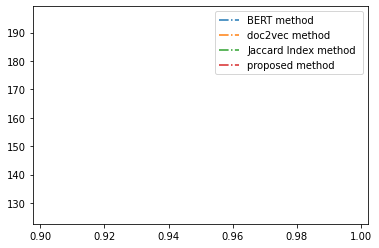

In [80]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# create data


y = story_len_dict_bert
x = omega_max_list
plt.plot(x, y, label = "BERT method ", linestyle="-." )

y = story_len_dict_doc2vec
plt.plot(x, y, label = "doc2vec method ", linestyle="-." )

y = story_len_dict_ji
plt.plot(x, y, label = "Jaccard Index method ", linestyle="-." )

y = story_len_dict_proposed
plt.plot(x, y, label = "proposed method ", linestyle="-." )

plt.legend()
plt.show()

In [81]:
#generate embedding for evaluation metrics
total_doc_embedding_cls = dict()
for doc in total_doc_embedding.keys():
  total_doc_embedding_cls[doc] = total_doc_embedding[doc]['cls']

Experimental Results

In [82]:
full_story_NYT_proposed_embedding = dict()
for omega in final_results_proposed.keys():
  temp_story_list = list()
  for story in final_results_proposed[omega]:
    temp_list = list()
    for doc in story:
      temp_list.append(total_doc_embedding_cls[doc])
    temp_story_list.append(temp_list)
  full_story_NYT_proposed_embedding[omega] = temp_story_list

In [83]:
full_story_NYT_bert_embedding = dict()
for omega in final_results_bert.keys():
  temp_story_list = list()
  for story in final_results_bert[omega]:
    temp_list = list()
    for doc in story:
      temp_list.append(total_doc_embedding_cls[doc])
    temp_story_list.append(temp_list)
  full_story_NYT_bert_embedding[omega] = temp_story_list

In [84]:
full_story_NYT_ji_embedding = dict()
for omega in final_results_ji.keys():
  temp_story_list = list()
  for story in final_results_ji[omega]:
    temp_list = list()
    for doc in story:
      temp_list.append(total_doc_embedding_cls[doc])
    temp_story_list.append(temp_list)
  full_story_NYT_ji_embedding[omega] = temp_story_list

In [85]:
full_story_NYT_doc2vec_embedding = dict()
for omega in final_results_doc2vec.keys():
  temp_story_list = list()
  for story in final_results_doc2vec[omega]:
    temp_list = list()
    for doc in story:
      temp_list.append(total_doc_embedding_cls[doc])
    temp_story_list.append(temp_list)
  full_story_NYT_doc2vec_embedding[omega] = temp_story_list

In [147]:
pickle.dump(full_story_NYT_proposed_embedding, open('drive/MyDrive/temp/data_last_version/full_story_NYT_proposed_embedding.p', 'wb'))
pickle.dump(full_story_NYT_bert_embedding, open('drive/MyDrive/temp/data_last_version/full_story_NYT_bert_embedding.p', 'wb'))
pickle.dump(full_story_NYT_ji_embedding, open('drive/MyDrive/temp/data_last_version/full_story_NYT_ji_embedding.p', 'wb'))
pickle.dump(full_story_NYT_doc2vec_embedding, open('drive/MyDrive/temp/data_last_version/full_story_NYT_doc2vec_embedding.p', 'wb'))

In [86]:
def story_stretch(story_list, max_omega):
  stories = story_list[max_omega]
  stories_length = list()
  for story in stories:
    stories_length.append(len(story))
  ave = np.average(stories_length)
  return 1- np.sqrt(np.average([pow(l_i - ave,2) for l_i in stories_length])) / len(stories)

In [87]:
thre = 0.95
print('StoryStretch Metric')
print(story_stretch(final_results_proposed, thre))
print(story_stretch(final_results_bert, thre))
print(story_stretch(final_results_ji, thre))
print(story_stretch(final_results_doc2vec, thre))
# print(story_stretch(final_results_doc2vec_n, thre))

StoryStretch Metric
0.8841218986391303
0.6159935710173592
0.8260073636615618
-4.878136629440915


In [88]:
omega_list = final_results_proposed.keys()
story_stretch_proposed = [story_stretch(final_results_proposed, i) for i in omega_list]
story_stretch_bert = [story_stretch(final_results_bert, i) for i in omega_list]
story_stretch_ji = [story_stretch(final_results_ji, i) for i in omega_list]
story_stretch_doc2vec = [story_stretch(final_results_doc2vec, i) for i in omega_list]



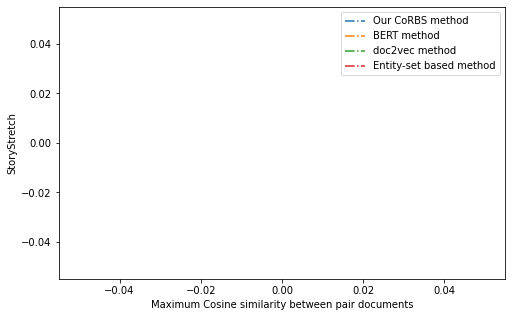

In [89]:


x = list(omega_list)[0:-1]
plt.figure(figsize=(8,5))

y = story_stretch_proposed[0:-1]
plt.plot(x, y, label = "Our CoRBS method ", linestyle="-." )

y = story_stretch_bert[0:-1]
plt.plot(x, y, label = "BERT method ", linestyle="-." )


y = story_stretch_doc2vec[0:-1]
plt.plot(x, y, label = "doc2vec method ", linestyle="-." )

y = story_stretch_ji[0:-1]
plt.plot(x, y, label = "Entity-set based method", linestyle="-." )

# y = story_stretch_doc2vec_n[0:-2]
# plt.plot(x, y, label = "doc2vec method ", linestyle="-." )

plt.xlabel('Maximum Cosine similarity between pair documents')
plt.ylabel('StoryStretch')

plt.legend()
plt.show()

In [90]:
def tempo_cover(story_list, timestamp_list, omega):
  stories_list = story_list[omega]
  res = list()
  for story in stories_list:
    ts_counter = set()
    for t_s in range(len(timestamp_list)):
      for doc in story:
        if doc in timestamp_list[t_s]:
          ts_counter.add(t_s)
    res.append(len(ts_counter)/len(story))
  return np.average(res)

        



In [91]:
print('TempoCover Metric')
print(tempo_cover(final_results_proposed, list_of_timestamps, thre))
print(tempo_cover(final_results_bert, list_of_timestamps, thre))
print(tempo_cover(final_results_ji, list_of_timestamps, thre))
print(tempo_cover(final_results_doc2vec, list_of_timestamps, thre))
# print(tempo_cover(final_results_doc2vec_n, list_of_timestamps, thre))

TempoCover Metric
0.5153716877776289
0.5097972909087782
0.43935807643045444
0.6483872369233519


In [92]:
omega_list = final_results_proposed.keys()
tempo_cover_proposed = [tempo_cover(final_results_proposed, list_of_timestamps, i) for i in omega_list]
tempo_cover_bert = [tempo_cover(final_results_bert, list_of_timestamps, i) for i in omega_list]
tempo_cover_ji = [tempo_cover(final_results_ji, list_of_timestamps, i) for i in omega_list]
tempo_cover_doc2vec = [tempo_cover(final_results_doc2vec, list_of_timestamps, i) for i in omega_list]


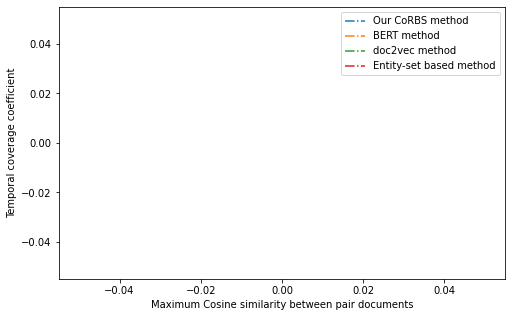

In [93]:
x = list(omega_list)[0:-2]
plt.figure(figsize=(8,5))

y = tempo_cover_proposed[0:-2]
plt.plot(x, y, label = "Our CoRBS method", linestyle="-." )

y = tempo_cover_bert[0:-2]
plt.plot(x, y, label = "BERT method ", linestyle="-." )


y = tempo_cover_doc2vec[0:-2]
plt.plot(x, y, label = "doc2vec method ", linestyle="-." )

y = tempo_cover_ji[0:-2]
plt.plot(x, y, label = "Entity-set based method", linestyle="-." )

# y = tempo_cover_doc2vec_n[0:-2]
# plt.plot(x, y, label = "doc2vec method ", linestyle="-." )

plt.xlabel('Maximum Cosine similarity between pair documents')
plt.ylabel('Temporal coverage coefficient')

plt.legend()
plt.show()

In [94]:
# #generate embedding for evaluation metrics


# total_doc_embedding = dict()
# for t_ in Embed_dict.keys():
#   for doc in Embed_dict[t_].keys():
#     total_doc_embedding[doc] = Embed_dict[t_][doc]


# total_doc_embedding_cls = dict()
# for doc in total_doc_embedding.keys():
#   total_doc_embedding_cls[doc] = total_doc_embedding[doc]['cls']


# full_story_NYT_proposed_embedding = dict()
# for omega in final_results_proposed.keys():
#   temp_story_list = list()
#   for story in final_results_proposed[omega]:
#     temp_list = list()
#     for doc in story:
#       temp_list.append(total_doc_embedding_cls[doc])
#     temp_story_list.append(temp_list)
#   full_story_NYT_proposed_embedding[omega] = temp_story_list


# full_story_NYT_bert_embedding = dict()
# for omega in final_results_bert.keys():
#   temp_story_list = list()
#   for story in final_results_bert[omega]:
#     temp_list = list()
#     for doc in story:
#       temp_list.append(total_doc_embedding_cls[doc])
#     temp_story_list.append(temp_list)
#   full_story_NYT_bert_embedding[omega] = temp_story_list


# full_story_NYT_ji_embedding = dict()
# for omega in final_results_ji.keys():
#   temp_story_list = list()
#   for story in final_results_ji[omega]:
#     temp_list = list()
#     for doc in story:
#       temp_list.append(total_doc_embedding_cls[doc])
#     temp_story_list.append(temp_list)
#   full_story_NYT_ji_embedding[omega] = temp_story_list


# full_story_NYT_doc2vec_embedding = dict()
# for omega in final_results_doc2vec.keys():
#   temp_story_list = list()
#   for story in final_results_doc2vec[omega]:
#     temp_list = list()
#     for doc in story:
#       temp_list.append(total_doc_embedding_cls[doc])
#     temp_story_list.append(temp_list)
#   full_story_NYT_doc2vec_embedding[omega] = temp_story_list


# full_story_NYT_doc2vec_embedding_n = dict()
# for omega in final_results_doc2vec_n.keys():
#   temp_story_list = list()
#   for story in final_results_doc2vec_n[omega]:
#     temp_list = list()
#     for doc in story:
#       temp_list.append(total_doc_embedding_cls[doc])
#     temp_story_list.append(temp_list)
#   full_story_NYT_doc2vec_embedding_n[omega] = temp_story_list

In [95]:
def disp(d_i, d_j, n, teta, i, j):
  a = np.array(d_i)
  b = np.array(d_j)
  dist = cosine_similarity([a],[b])[0][0]
  if dist < teta:
    return 1/(n+i-j)
  else:
    return 0


# def disp(d_i, d_j, n, teta, i, j):
#   a = np.array(d_i)
#   b = np.array(d_j)
#   dist = np.sqrt(np.sum(np.square(a-b))) / len(d_i)
#   if dist < teta:
#     return 1/(n+i-j)
#   else:
#     return 0


In [96]:
def final_disp(story_, teta):
  res = list()
  len_story = len(story_)
  for i in range(len_story-3):
    for j in range(i+2, len_story-1):
      res.append(disp(story_[i], story_[j], len_story, teta, i, j))
  
  return 1.0 - (sum(res)/(len_story-2 + 0.01))

In [97]:
# disp_porposed = list()
# disp_bert = list()
# disp_ji = list()
# disp_doc2vec = list()
# # omega_list = [0.9]
# for om in tqdm(omega_list): 
#   g_value = [final_disp(x, 0.025) for x in full_story_NYT_proposed_embedding[om]]
#   disp_porposed.append(sum(g_value)/ len(g_value))
#   f_value = [final_disp(x, 0.025) for x in full_story_NYT_bert_embedding[om]]
#   disp_bert.append(sum(f_value)/ len(f_value))
#   z_value = [final_disp(x, 0.025) for x in full_story_NYT_ji_embedding[om]]
#   disp_ji.append(sum(z_value)/  len(z_value))
#   a_value = [final_disp(x, 0.025) for x in full_story_NYT_doc2vec_embedding[om]]
#   disp_doc2vec.append(sum(a_value)/len(a_value))



disp_porposed = list()
disp_bert = list()
disp_ji = list()
disp_doc2vec = list()
disp_doc2vec_n = list()
teta_list = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
for te_ta in tqdm(teta_list): 
  g_value = [final_disp(x, te_ta) for x in full_story_NYT_proposed_embedding[0.95]]
  disp_porposed.append(sum(g_value)/ len(g_value))
  f_value = [final_disp(x, te_ta) for x in full_story_NYT_bert_embedding[0.95]]
  disp_bert.append(sum(f_value)/ len(f_value))
  z_value = [final_disp(x, te_ta) for x in full_story_NYT_ji_embedding[0.95]]
  disp_ji.append(sum(z_value)/  len(z_value))
  a_value = [final_disp(x, te_ta) for x in full_story_NYT_doc2vec_embedding[0.95]]
  disp_doc2vec.append(sum(a_value)/len(a_value))


100%|██████████| 6/6 [09:28<00:00, 94.77s/it]


In [98]:
i = -1
print('Dispersion Coefficient metric')

print(disp_porposed[i])
print(disp_bert[i])
print(disp_ji[i])
print(disp_doc2vec[i])
# print(disp_doc2vec_n[3])

Dispersion Coefficient metric
0.04181571934411506
0.04954983230293328
0.03257833638212573
0.16219253997767724


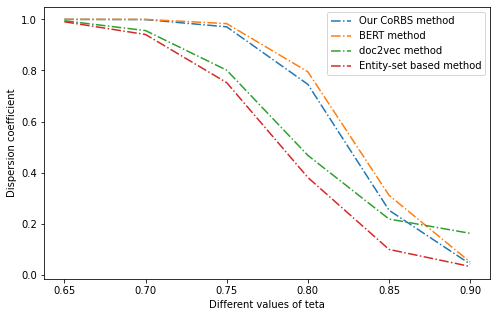

In [99]:


x = teta_list
plt.figure(figsize=(8,5))





# y = disp_doc2vec_n
# plt.plot(x, y, label = "doc2vec method ", linestyle="-." )



y = disp_porposed
plt.plot(x, y, label = "Our CoRBS method", linestyle="-." )
y = disp_bert
plt.plot(x, y, label = "BERT method ", linestyle="-." )
y = disp_doc2vec
plt.plot(x, y, label = "doc2vec method ", linestyle="-." )
y = disp_ji
plt.plot(x, y, label = "Entity-set based method", linestyle="-." )

plt.xlabel('Different values of teta')
plt.ylabel('Dispersion coefficient')
plt.legend()
plt.show()

In [100]:
def story_evaluation_avg (stories_embedding, t_max):
  n_stories = len(stories_embedding)
  res = list()
  for story in stories_embedding:
    temp_res = list()
    for i in range(len(story)-1):
      temp = cosine_similarity([story[i]], [story[i+1]])[0][0]
      temp_res.append(  (10*t_max - 10*temp + 1)* np.exp( -10*(t_max - temp))   )
    res.append(np.average(temp_res))
  return np.average(res)


def story_evaluation_vec (stories_embedding, t_max):
  n_stories = len(stories_embedding)
  res = list()
  for story in stories_embedding:
    temp_res = list()
    for i in range(len(story)-1):
      temp = cosine_similarity([story[i]], [story[i+1]])[0][0]
      temp_res.append(  (10*t_max - 10*temp + 1)* np.exp( -10*(t_max - temp))   )
    res.append(np.average(temp_res))
  return res


In [101]:
print('Story Evolution Coefficient (SEC)')
s_sa = full_story_NYT_proposed_embedding[thre]
print(story_evaluation_avg(s_sa, thre))
s_sa = full_story_NYT_doc2vec_embedding[thre]
print(story_evaluation_avg(s_sa, thre))
s_sa = full_story_NYT_ji_embedding[thre]
print(story_evaluation_avg(s_sa, thre))
s_sa = full_story_NYT_bert_embedding[thre]
print(story_evaluation_avg(s_sa, thre))
# s_sa = full_story_NYT_doc2vec_embedding_n[0.9]
# print(story_evaluation_avg(s_sa, 0.9))

Story Evolution Coefficient (SEC)
0.729490234251877
0.5391016588481158
0.541815196346136
0.8262705377124928


In [102]:
NYT_proposed = (story_evaluation_vec(full_story_NYT_proposed_embedding[thre], thre))
NYT_doc2vec = (story_evaluation_vec(full_story_NYT_doc2vec_embedding[thre], thre))
# NYT_doc2vec_n = (story_evaluation_vec(full_story_NYT_doc2vec_embedding_n[0.9], 0.9))
NYT_ji = (story_evaluation_vec(full_story_NYT_ji_embedding[thre], thre))
NYT_bert = (story_evaluation_vec(full_story_NYT_bert_embedding[thre], thre))


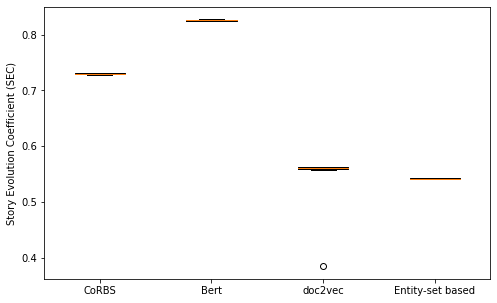

In [151]:
data = [NYT_proposed, NYT_bert, NYT_doc2vec, NYT_ji]
 
plt.figure(figsize=(8,5))
 
plt.boxplot(data,showfliers=True,labels=['CoRBS','Bert','doc2vec', "Entity-set based"])
plt.ylabel("Story Evolution Coefficient (SEC)")

plt.show()

In [178]:
import csv
#print stories generated by different models
dict_story_proposed = dict()

c = 0;
for stories in final_results_proposed[thre]:
  # print('Story #{}'.format(c))
  c += 1
  temp_doc = list()
  for doc in stories:
    # print(doc)
    temp = df[df['id']== doc]
    if list(temp.values):
      # print(temp.values)
      temp_doc.append(temp.values[0])
  dict_story_proposed[c] = temp_doc

for ind in range(c):
    
  with open('drive/MyDrive/temp/data_last_version/csv_stories/proposed_stories'+str(ind)+'.csv', 'w') as f:
        
      # using csv.writer method from CSV package
      write = csv.writer(f)
        
      write.writerow(list(df.columns))
      write.writerows(temp_doc)


In [179]:

#print stories generated by different models
dict_story_bert = dict()

c = 0;
for stories in final_results_bert[thre]:
  # print('Story #{}'.format(c))
  c += 1
  temp_doc = list()
  for doc in stories:
    # print(doc)
    temp = df[df['id']== doc]
    if list(temp.values):
      # print(temp.values)
      temp_doc.append(temp.values[0])
  dict_story_bert[c] = temp_doc

for ind in range(c):
    
  with open('drive/MyDrive/temp/data_last_version/csv_stories/bert_stories'+str(ind)+'.csv', 'w') as f:
        
      # using csv.writer method from CSV package
      write = csv.writer(f)
        
      write.writerow(list(df.columns))
      write.writerows(temp_doc)

In [180]:
#print stories generated by different models
dict_story_doc2vec = dict()

c = 0;
for stories in final_results_doc2vec[thre]:
  # print('Story #{}'.format(c))
  c += 1
  temp_doc = list()
  for doc in stories:
    # print(doc)
    temp = df[df['id']== doc]
    if list(temp.values):
      # print(temp.values)
      temp_doc.append(temp.values[0])
  dict_story_doc2vec[c] = temp_doc

for ind in range(c):
    
  with open('drive/MyDrive/temp/data_last_version/csv_stories/doc2vec_stories'+str(ind)+'.csv', 'w') as f:
        
      # using csv.writer method from CSV package
      write = csv.writer(f)
        
      write.writerow(list(df.columns))
      write.writerows(temp_doc)

In [181]:
#print stories generated by different models
dict_story_ji = dict()

c = 0;
for stories in final_results_ji[thre]:
  # print('Story #{}'.format(c))
  c += 1
  temp_doc = list()
  for doc in stories:
    # print(doc)
    temp = df[df['id']== doc]
    if list(temp.values):
      # print(temp.values)
      temp_doc.append(temp.values[0])
  dict_story_ji[c] = temp_doc

for ind in range(c):
    
  with open('drive/MyDrive/temp/data_last_version/csv_stories/ji_stories'+str(ind)+'.csv', 'w') as f:
        
      # using csv.writer method from CSV package
      write = csv.writer(f)
        
      write.writerow(list(df.columns))
      write.writerows(temp_doc)